# GWAS Project on eye color

In this project you will be looking at GWAS data from openSNP, which is a web site where users of direct-to-customer genetic tests can share their personal data with other users. The phenotype we will be looking at is self-reported eye color. When looking at the data you should be aware that:

* The data comes from different companies that use different chips so there are markers that are missing from some individuals because they were not present on the chip used by their company.


* The gender information is missing from the file and by default plink will ignore the phenotype of individuals without gender information. So you have to use “--allow-no-sex” option in plink.


# <ins>Load R libraries</ins>

In [1]:
library(dplyr)
library(ggplot2)
library(qqman)
library(tidyr)
library(gridExtra)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.




Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




## Quality Control

Quality control is a vital step that should be part of any GWAS. Without this crucial step the results obtained would not be reliable because our input data is inherently imperfect. 
These imperfections arise for different reasons such poor quality DNA samples or contaminations. 

The idea behind quality control is to filter out SNPs and individuals based on the following:

**1-	Individual and SNP missingness:**

The number of SNPs that is missing for a specific individual. High values indicate poor quality.

**2-	Inconsistencies in assigned and genetic sex of subjects (not applicable in our case)**
**3-	Minor allele frequency (MAF):**

The frequency of the least often occurring allele at a specific location. It is hard to detect associations with SNPs with a low MAF, so they should be excluded. 

**4-	Deviations from Hardy-Weinberg equilibrium:**

Concerns the relation between allele and genotype frequencies. It assumes an infinitely large population, with no selection, no mutation and no migration. And it states that genotype and allele frequencies are constant over generations. 
A violation of HWE indicates that genotype frequencies are significantly different from the expected.

For example, if we have two alleles A and T, with respective frequencies of 0.2 and 0.8, we expect the frequency of AT to be 2*(0.2*0.8) = 0.32
The observed frequency should not be significantly different. 

Deviations from this are the result of genotyping errors, and can be indicative of true genetic association with the phenotype. 

**5-	Heterozygosity rate:**

Is the carrying of two different alleles of a specific SNP. Is the proportion of heterozygous genotypes. A high value may indicate low quality in the sample. 

**6-	Relatedness:**

It is important to know how strongly a pair of individuals is genetically related. We should assume that all subjects in our GWAS should be unrelated. 
Without correction, the inclusion of relatives could lead to biased results. 

**7-	Ethnic outliers (population stratification) (not applicable in our case)**

### <ins>Filter by missigness and heterozygosity</ins>

We start by filtering out individuals with high SNP missigness, since they indicate lower DNA quality or concentration. We also want to remove individuals showing a high heterozygosity sites, since these can be a product of contamination, and individuals showing a low proportion of heterozygous sites, since these low values are indicative of inbreeding.

To do that, we run two plink commands in the terminal:

    plink --bfile eye_color --missing --allow-no-sex --out eyecolor-QC 
    
    plink --bfile eye_color --het -- allow-no-sex --out eyecolor-QC

The first command will generate a "imiss" file, which contains per-sample missigness information. This file contains the name of the sample and family IDs, as well as one column for missing phenotype, one column for the number of missing genotypes, one column for the number of genotypes and one column for the proportion of missing genotypes.

The second command will generate a ".het" file that contains one column for the number of homozygotes, one column for the expected number of homozygotes (computed using allele frequencies estimated from the dataset), one column for the number of non-missing genotypes and finally one column with the estimated inbreeding coefficient.

We can join the datasets and comupte the heterozygosity as:
    
    het_rate = (N.NM. - O.HOM.)/N.NM

Which corresponds to the proportion of heterozygous sites (excluding missing genotypes since we are using N.NM as total).

In [2]:
d_miss <- read.table("eyecolor-QC.imiss",header=T)
d_het <- read.table("eyecolor-QC.het",header=T)
d <- inner_join(d_miss,d_het)

d <- d %>% mutate(het_rate = (N.NM.-O.HOM.)/N.NM.) %>% mutate(prop_miss = N_MISS/N.NM.)
head(d)

Joining, by = c("FID", "IID")



,FID,IID,MISS_PHENO,N_MISS,N_GENO,F_MISS,O.HOM.,E.HOM.,N.NM.,F,het_rate,prop_miss
,<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1010,1010,Y,417559,958847,0.435500,355012,353100,522943,0.011510,0.3211268,0.798478993
2,1013,1013,Y,1589,958847,0.001657,622171,618900,897402,0.011880,0.3066976,0.001770667
3,1020,1020,Y,3555,958847,0.003708,620700,617700,895619,0.010850,0.3069598,0.003969322
4,1022,1022,Y,23735,958847,0.024750,609152,605200,877300,0.014590,0.3056514,0.027054599
5,1024,1024,Y,23896,958847,0.024920,606768,605000,876929,0.006683,0.3080763,0.027249641
6,1026,1026,Y,23264,958847,0.024260,611711,605300,877569,0.023400,0.3029483,0.026509596


Plotting the proportion of missingness:

[1] 0.314062

[1] 0.01186815

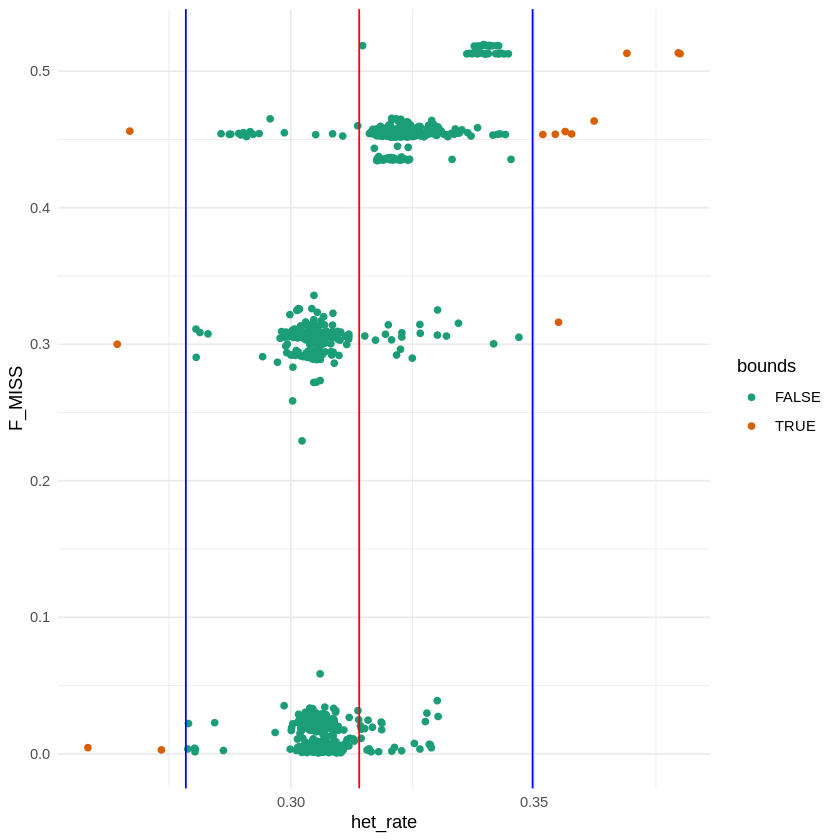

In [3]:
(mean_heterozygosiy  <- mean(d$het_rate))
(sd_heterozygosity  <- sd(d$het_rate))

d  %>% mutate(bounds = abs(het_rate-mean_heterozygosiy) > 3*sd_heterozygosity) %>% 
ggplot()+
geom_point(aes(x=het_rate,y=F_MISS,color=bounds)) +
geom_vline(xintercept = mean_heterozygosiy, color ="red")+
geom_vline(xintercept = mean_heterozygosiy-3*sd_heterozygosity, color ="blue")+
geom_vline(xintercept = mean_heterozygosiy+3*sd_heterozygosity, color ="blue") +  scale_color_brewer(palette="Dark2") + theme_minimal()

We can see the data comes from four different chips, if we filter by missingness we will be removing the data from some chips and we don't want to do that. 
Also if we filter by heterozygosity we will be missing a lot of information because every chip has a different mean in heterozygosity.

We now filter out individuals showing more than 3% of per-individual missing proportion of genotypes (F_MISS), and with heterozigpsity rates that are 3 standard deviations from the mean.

In [4]:
tofilter <- d %>% 
    filter(abs(het_rate-mean_heterozygosiy) > 3*sd_heterozygosity)
head(tofilter)
dim(tofilter)


#We output the file with the IDs of the ones that have to be removed
tofilter %>% select(FID, IID) %>% 
    write.table(file = "wrong_het_missing_values.txt", sep = "\t",
            row.names = FALSE, col.names = FALSE)

,FID,IID,MISS_PHENO,N_MISS,N_GENO,F_MISS,O.HOM.,E.HOM.,N.NM.,F,het_rate,prop_miss
,<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,2053,2053,Y,287683,958847,0.300000,481143,451900,654052,0.14450,0.2643658,0.43984729
2,2887,2887,Y,437005,958847,0.455800,318819,333900,495340,-0.09349,0.3563633,0.88223241
3,2907,2907,Y,437299,958847,0.456100,362792,333600,494902,0.18080,0.2669417,0.88360726
4,3783,3783,Y,444472,958847,0.463500,311908,329600,489119,-0.11110,0.3623065,0.90871955
5,4006,4006,Y,435150,958847,0.453800,320729,334900,496740,-0.08743,0.3543322,0.87601160
6,44,44,Y,2768,958847,0.002887,651807,618700,897111,0.11900,0.2734377,0.00308546


[1] 13 12

13 individuals don't pass the filter and will be removed using the following plink line of code:
    
    plink --bfile eyecolor-QC --remove wrong_het_missing_values.txt "--make-bed" --out eyecolor-QC


<span style="color:blue">**A. Are there any closely related individuals in the sample?**</span>
### <ins>Filter by relatedness</ins>


Our next step is the identification and removal of duplicated or related individuals **(Identity By Descent IBD)**. 

If our data has closely related individuals we will in increase the frequency of their genotypes without regard for their phenotypes and we would end up with a biased allele frequency distribution. 

The way this is solved is by using Plink, which can compute genome-wide IBD estimates as long as they are independent. Because of that we first need to identify independent sites and compute the IBD estimates only on there. 
This is done with the following command:

    plink --bfile eye_color --indep-pairwise 500kb 5 0.2 --out eyecolor-QC
    
This command uses a window size of 500kb, a step size of 5 and a pairwise r2 threshold of 0.2, and will output a file called "GWA-QC.prune.in" with the independent SNPs. This file will be used to calculate the IBD between each pair of individuals using this command: 

    plink --bfile eye_color --extract GWA-QC.prune.in --genome --min 0.185 --out eyecolor-QC
    
This will output a file "GWA-QC.genome".

In [5]:
ibd <- read.table('GWA-QC.genome', header = TRUE)
ibd
members <- ibd$FID1
members <- unique(members)
members
#write.table(cbind(members,members), file = 'wrong_ibd.txt', col.names = F, row.names = F)

FID1,IID1,FID2,IID2,RT,EZ,Z0,Z1,Z2,PI_HAT,PHE,DST,PPC,RATIO
<int>,<int>,<int>,<int>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1173,1173,4814,4814,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
1269,1269,1275,1275,UN,NA,0.0016,0.9588,0.0396,0.5190,-1,0.873488,1,1847.0000
1424,1424,6035,6035,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
1775,1775,2083,2083,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
2651,2651,912,912,UN,NA,0.0020,0.9748,0.0232,0.5106,-1,0.871290,1,1146.0000
3998,3998,6191,6191,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
4460,4460,5895,5895,UN,NA,0.0000,0.0000,1.0000,1.0000,-1,1.000000,1,NA
4547,4547,4632,4632,UN,NA,0.5346,0.4654,0.0000,0.2327,-1,0.805051,1,4.2938
4583,4583,4584,4584,UN,NA,0.2423,0.5276,0.2301,0.4939,-1,0.879427,1,11.0065


[1] 1173 1269 1424 1775 2651 3998 4460 4547 4583 4584 5792  651 8915 9277

These individuals can be twins, or can be error duplicates. To remove these individuals, we will use again the --remove parameter and create updated bed/bim/fam files:
    
    plink --bfile eye_color --remove wrong_ibd.txt --geno 0.75 --hwe 0.00001 --maf 0.01 --make-bed --out eye_color-QC

### <ins>Filter by SNP</ins>

We want to investigate SNPs with an excessive missingness. 

This is done by simply running this command on Plink:

    plink --bfile eyecolor-QC --missing --out eyecolor-QC

,CHR,SNP,N_MISS,N_GENO,F_MISS
,<int>,<chr>,<int>,<int>,<dbl>
1,1,rs4477212,633,1283,0.49340
2,1,rs3094315,715,1283,0.55730
3,1,rs3131972,41,1283,0.03196
4,1,rs12124819,281,1283,0.21900
5,1,rs11240777,35,1283,0.02728
6,1,rs6681049,594,1283,0.46300


Warning message:
“Removed 1766 rows containing non-finite values (stat_bin).”


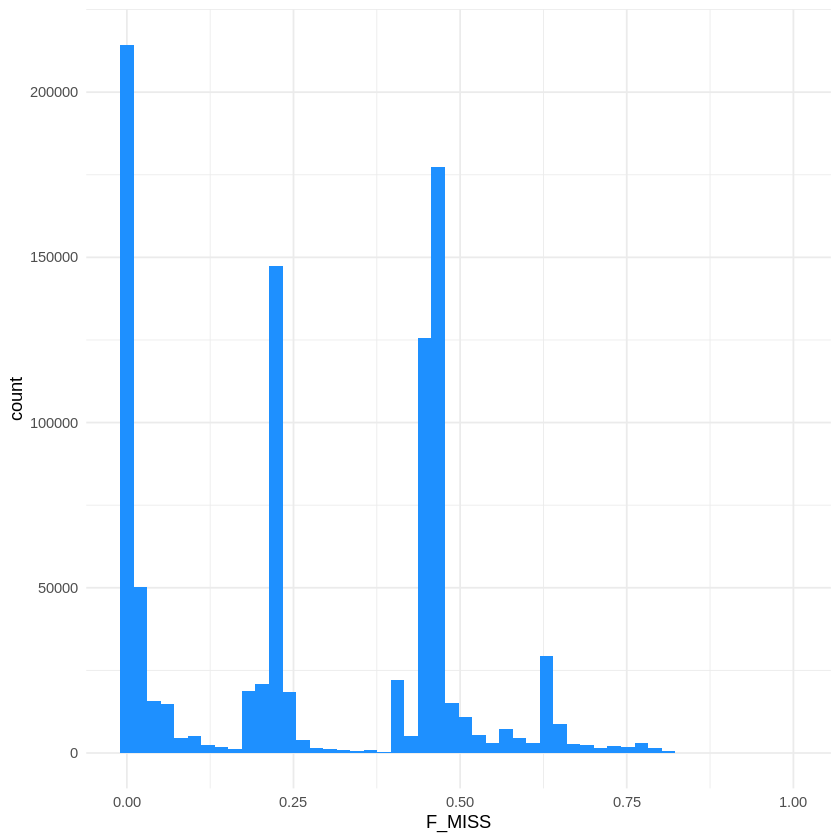

In [6]:
lmiss <- read.table("eyecolor-QC.lmiss", header = T)
head(lmiss)
lmiss %>%
    ggplot(aes(x=F_MISS)) +
    geom_histogram(bins=50,fill="dodgerblue") + theme_minimal()

<span style="color:blue">**B. Do a PCA plot. What does it tell you about the samples?**</span>
### PCA

To do the PCA we first associate phenotypes_binary.txt to the fam file:

In [7]:
eyecolor_qc<-read.table("eye_color-QC.fam")
phenotypes_binary<-read.table("phenotypes_binary.txt")
colnames(phenotypes_binary)<-c("FID","IID","PHENO")
colnames(eyecolor_qc)<-c("FID","IID","PAT","MAT","SEX","PHENO")


eyecolor_qc$PHENO <- phenotypes_binary$PHENO[match(eyecolor_qc$FID, phenotypes_binary$FID)]

dim(eyecolor_qc)

eyecolor_qc_binary<-eyecolor_qc

head(eyecolor_qc_binary)

[1] 1273    6

,FID,IID,PAT,MAT,SEX,PHENO
,<int>,<int>,<int>,<int>,<int>,<int>
1,1010,1010,0,0,0,2
2,1013,1013,0,0,0,2
3,1020,1020,0,0,0,1
4,1022,1022,0,0,0,1
5,1024,1024,0,0,0,1
6,1026,1026,0,0,0,2


Now on Plink we do the prunning of linked variants:
    
    plink --bfile eye_color-QC --indep-pairwise 500kb 5 0.2 --out eyecolor-QC-prunned

To use the pruned set of SNPs to calculate the relationship matrix and calculate the first 20 principle components (PCs):

    plink --bfile eye_color-QC --extract eyecolor-QC-prunned.prune.in --pca 20 --out eyecolor-QC-prunned


Joining, by = c("FID", "IID")



,FID,IID,ID_father,ID_mother,sex,pheno,PC1,PC2,PC3,PC4,⋯,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1010,1010,0,0,0,2,0.00223217,-0.00638386,0.01826570,0.01816860,⋯,-0.00783101,0.003217390,-0.00427055,-0.01283960,0.01534530,-0.014767900,0.005407620,0.000853849,0.000443868,0.00578052
2,1013,1013,0,0,0,2,0.01222780,-0.00268695,-0.00939051,-0.01208410,⋯,-0.00260934,0.003090290,0.00261714,-0.00925433,-0.00410425,-0.000116316,0.010455400,0.003604870,0.001126190,-0.00724107
3,1020,1020,0,0,0,1,0.01047720,-0.00495734,-0.01033880,-0.01555610,⋯,-0.00341487,0.000477128,0.00435435,0.00422094,0.00733322,0.001508530,-0.005281730,-0.001833850,-0.000456253,-0.00519657
4,1022,1022,0,0,0,1,0.01154630,-0.00287581,-0.00887270,-0.01276190,⋯,-0.00974093,0.002306710,0.00456258,0.00287690,-0.00081557,0.000938075,0.001927780,0.000453877,-0.001328780,0.00420229
5,1024,1024,0,0,0,1,0.00763315,-0.00232551,-0.00361583,-0.00617406,⋯,0.00588120,0.003884400,0.00147809,0.01232990,0.00279200,-0.005994700,0.000751792,-0.003416220,-0.002015100,0.00526009
6,1026,1026,0,0,0,2,0.01068370,-0.00298013,-0.01197730,-0.01143900,⋯,-0.00231450,0.003259620,0.00484131,0.00580049,-0.00107445,-0.003208450,-0.004551200,0.005380660,-0.002097230,-0.00954112


,FID,IID,ID_father,ID_mother,sex,pheno,PC1,PC2,PC3,PC4,⋯,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
,<int>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1010,1010,0,0,0,Dark Color,0.00223217,-0.00638386,0.01826570,0.01816860,⋯,-0.00783101,0.003217390,-0.00427055,-0.01283960,0.01534530,-0.014767900,0.005407620,0.000853849,0.000443868,0.00578052
2,1013,1013,0,0,0,Dark Color,0.01222780,-0.00268695,-0.00939051,-0.01208410,⋯,-0.00260934,0.003090290,0.00261714,-0.00925433,-0.00410425,-0.000116316,0.010455400,0.003604870,0.001126190,-0.00724107
3,1020,1020,0,0,0,Light Color,0.01047720,-0.00495734,-0.01033880,-0.01555610,⋯,-0.00341487,0.000477128,0.00435435,0.00422094,0.00733322,0.001508530,-0.005281730,-0.001833850,-0.000456253,-0.00519657
4,1022,1022,0,0,0,Light Color,0.01154630,-0.00287581,-0.00887270,-0.01276190,⋯,-0.00974093,0.002306710,0.00456258,0.00287690,-0.00081557,0.000938075,0.001927780,0.000453877,-0.001328780,0.00420229
5,1024,1024,0,0,0,Light Color,0.00763315,-0.00232551,-0.00361583,-0.00617406,⋯,0.00588120,0.003884400,0.00147809,0.01232990,0.00279200,-0.005994700,0.000751792,-0.003416220,-0.002015100,0.00526009
6,1026,1026,0,0,0,Dark Color,0.01068370,-0.00298013,-0.01197730,-0.01143900,⋯,-0.00231450,0.003259620,0.00484131,0.00580049,-0.00107445,-0.003208450,-0.004551200,0.005380660,-0.002097230,-0.00954112


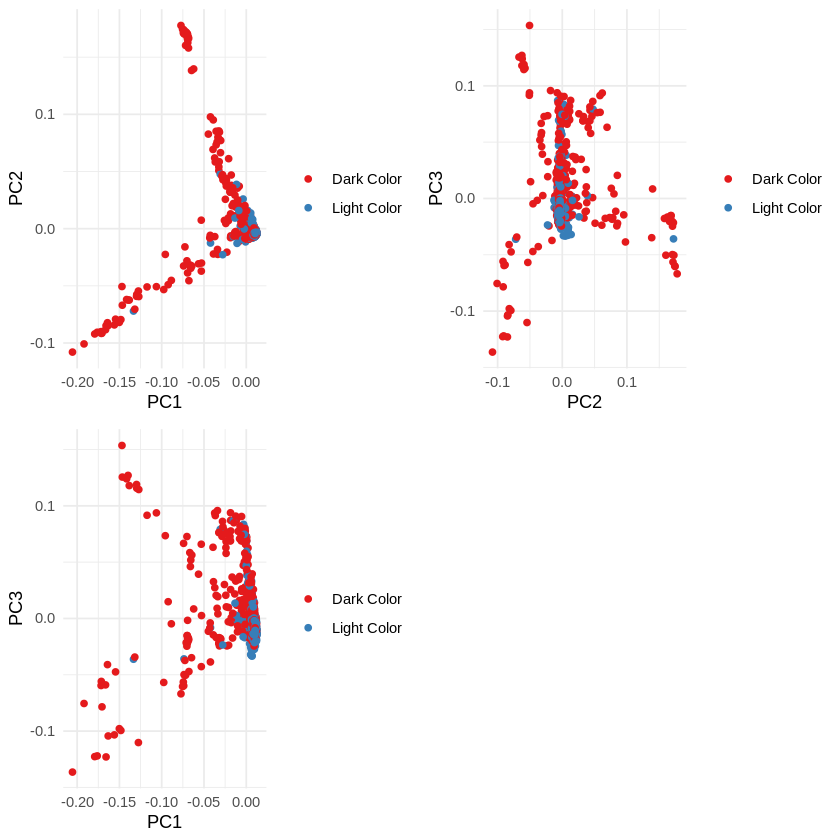

In [8]:
eigen_vect <- read.table("eyecolor-QC-prunned.eigenvec")
names(eigen_vect) <- c(c("FID","IID"),paste(rep("PC",20),seq(1,20),sep=""))

# Use fam file to get pheno status
fam <- read.table("eyecolor-QC.fam",header=F)
names(eyecolor_qc) <- c("FID","IID","ID_father","ID_mother","sex","pheno")
eigen_vect <- inner_join(eyecolor_qc,eigen_vect)
head(eigen_vect)

toplot<-eigen_vect %>% 
    mutate(pheno = recode(pheno, 
                      "1" = "Light Color", 
                      "2" = "Dark Color"))

plot1<-toplot %>% ggplot() +
  geom_point(aes(x=PC1,y=PC2,color=as.factor(pheno))) +
  theme_minimal() +
  scale_color_brewer(palette="Set1") +
  theme(legend.title=element_blank())



head(toplot)
plot2<-toplot %>% ggplot() +
  geom_point(aes(x=PC2,y=PC3,color=as.factor(pheno))) +
  theme_minimal() +
  scale_color_brewer(palette="Set1") +
  theme(legend.title=element_blank())


plot3<-toplot %>% ggplot() +
  geom_point(aes(x=PC1,y=PC3,color=as.factor(pheno))) +
  theme_minimal() +
  scale_color_brewer(palette="Set1") +
  theme(legend.title=element_blank())

grid.arrange(plot1,plot2,plot3, nrow=2)

In [9]:
eigen_val <- as.data.frame(read.table("eyecolor-QC-prunned.eigenval"))
eigen_val <- eigen_val %>%
  mutate(per_var_expl=(V1/sum(eigen_val$V1))*100)

cat("The first PC approx explains ",eigen_val$per_var_expl[1],"% of the variance")

The first PC approx explains  36.5172 % of the variance

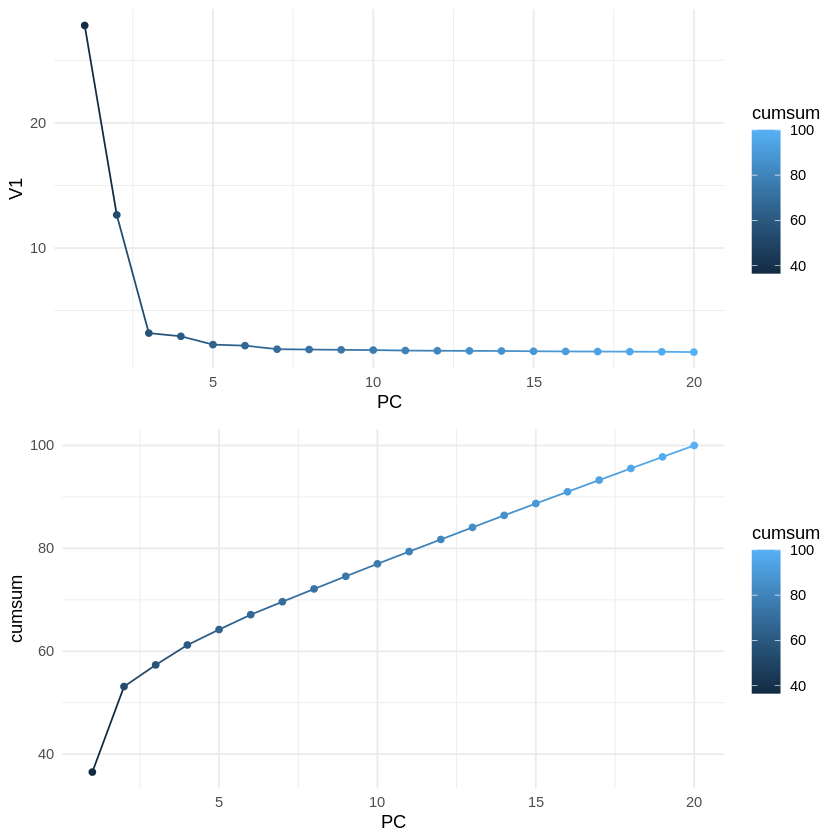

In [10]:
eigenval <- read.table("eyecolor-QC-prunned.eigenval", header = F)
eigenval <- eigenval %>% 
    mutate(variance_expl = V1/sum(V1)*100) %>% 
    mutate(PC = seq(1,20)) %>% 
    mutate(cumsum = cumsum(variance_expl))
eigenval_plot<-eigenval %>% 
    ggplot() +
        geom_line(aes(x = PC, y = V1,color=cumsum)) + geom_point(aes(x=PC,y=V1,color=cumsum))+ theme_minimal()
eigenval_plot2<-eigenval %>% 
    ggplot() +
        geom_line(aes(x = PC, y = cumsum,color=cumsum)) + geom_point(aes(x=PC, y = cumsum, color=cumsum)) + theme_minimal()

grid.arrange(eigenval_plot,eigenval_plot2, nrow=2)

As we can see the variance is mostly explained by the first PCs, however it seems we need to use all of them if we want to have a complete explanation of the data. 

## Association Tests

<span style="color:blue">**C. The file eye_color.txt contains the self-reported eye colors for the individuals in the data set. Do a GWAS on on the dataset. There are 12 categories and you can group some of them together to create a binary phenotype. How many significant loci do you find?** </span>


### Fisher's exact test 
The basic association test is based on comparing allele frequencies between cases and controls. 
We want to see if there is an association between certain SNPs and eye color, to simplify we will simplify the phenotypes into light or dark eye color.


In [11]:
eyecolor<-read.table("eye_color.txt", header = FALSE)
names(eyecolor) <- c("IID", "eye_color")
binary_eyecolor <- eyecolor %>% 
    mutate(FID = IID) %>% 
    mutate(response = case_when(eye_color == "amber-brown" ~ 2,
                                eye_color == "brown" ~ 2,
                                eye_color == "dark_brown" ~ 2,
                                eye_color == "hazel/brown-green" ~ 2,
                                TRUE ~ 1)) %>% 
    select(FID, IID, response)

head(binary_eyecolor)
dim(binary_eyecolor)

#write.table(binary_eyecolor, "phenotypes_binary.txt", col.names = FALSE, row.names = FALSE)

,FID,IID,response
,<int>,<int>,<dbl>
1,1010,1010,2
2,1013,1013,2
3,1020,1020,1
4,1022,1022,1
5,1024,1024,1
6,1026,1026,2


[1] 1287    3

To perform a standard case/control association analysis using Fisher's exact test to generate significance, we can use the command:

    plink --bfile eye_color-QC --assoc fisher --allow-no-sex --pheno phenotypes_binary.txt --out eyecolor

with --assoc will make PLINK report allele counts, rather than frequencies, in cases and controls.

This command will output a assoc.fisher file that contains the following information:

CHR: Chromosome

SNP: SNP ID

BP: Physical position (base-pair)

A1: Minor allele name (based on whole sample)

F_A: Frequency of this allele in cases

F_U: Frequency of this allele in controls

A2: Major allele name

P: Exact p-value for this test

OR: Estimated odds ratio (for A1)

In [12]:
assoc_fisher <- read.table("eyecolor.assoc.fisher", header = T)
head(assoc_fisher)
dim(assoc_fisher)

,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR
,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,1,rs3094315,752566,G,0.20140,0.17930,A,0.36340,1.1540
2,1,rs3131972,752721,A,0.21430,0.18910,G,0.12010,1.1700
3,1,rs12124819,776546,G,0.20390,0.23330,A,0.11500,0.8418
4,1,rs11240777,798959,A,0.26090,0.21490,G,0.00822,1.2900
5,1,rs6681049,800007,T,0.02907,0.00885,C,0.00876,3.3530
6,1,rs4970383,838555,A,0.26350,0.26270,C,1.00000,1.0040


[1] 838874      9

In [13]:
ass_fisher <- read.table("eyecolor.assoc.fisher",header=T)
#Most significant SNPs in order:
head(ass_fisher[order(ass_fisher$P),])
# Bonferroni correction
alpha <- 0.05/nrow(ass_fisher)

cat("Significance value after Bonferroni correction is: ",alpha)
cat("\nMost significant SNP is ",ass_fisher[which.min(ass_fisher$P),]$SNP)
cat("\nP value of most significant SNP is ",min(ass_fisher$P))
cat("\nIs the P value significant after Bonferroni correction? ",min(ass_fisher$P)<=alpha)

,CHR,SNP,BP,A1,F_A,F_U,A2,P,OR
,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
677659,15,rs1667394,28530182,C,0.3990,0.04570,T,6.019e-102,13.8600
677656,15,rs916977,28513364,T,0.3869,0.04520,C,1.850e-94,13.3300
677657,15,rs8039195,28516084,C,0.3543,0.04461,T,7.375e-74,11.7500
677642,15,rs4778241,28338713,A,0.3589,0.07980,C,2.387e-68,6.4540
677652,15,rs11636232,28386626,T,0.1912,0.48990,C,4.053e-57,0.2462
677650,15,rs3935591,28374012,T,0.3831,0.04062,C,7.983e-57,14.6600


Significance value after Bonferroni correction is:  5.960371e-08
Most significant SNP is  rs1667394
P value of most significant SNP is  6.019e-102
Is the P value significant after Bonferroni correction?  TRUE

As we can see the six most significant SNPs can all be found in CHR 15, but how does the data look? 

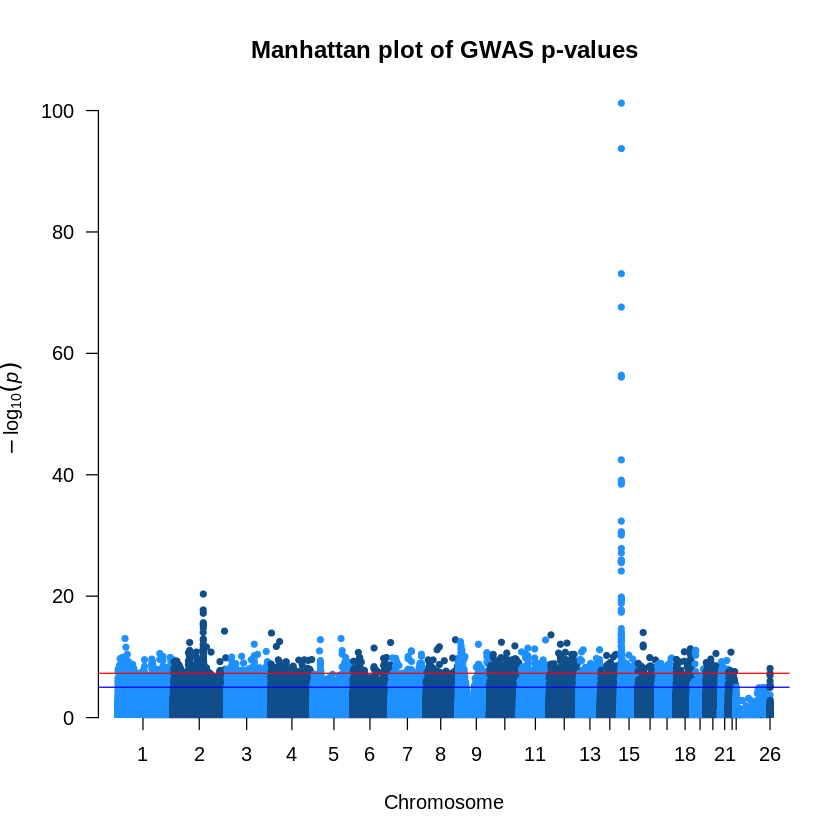

In [14]:
manhattan(ass_fisher,col = c("dodgerblue", "dodgerblue4"),main = "Manhattan plot of GWAS p-values")

We can see something is up in chromosome 15

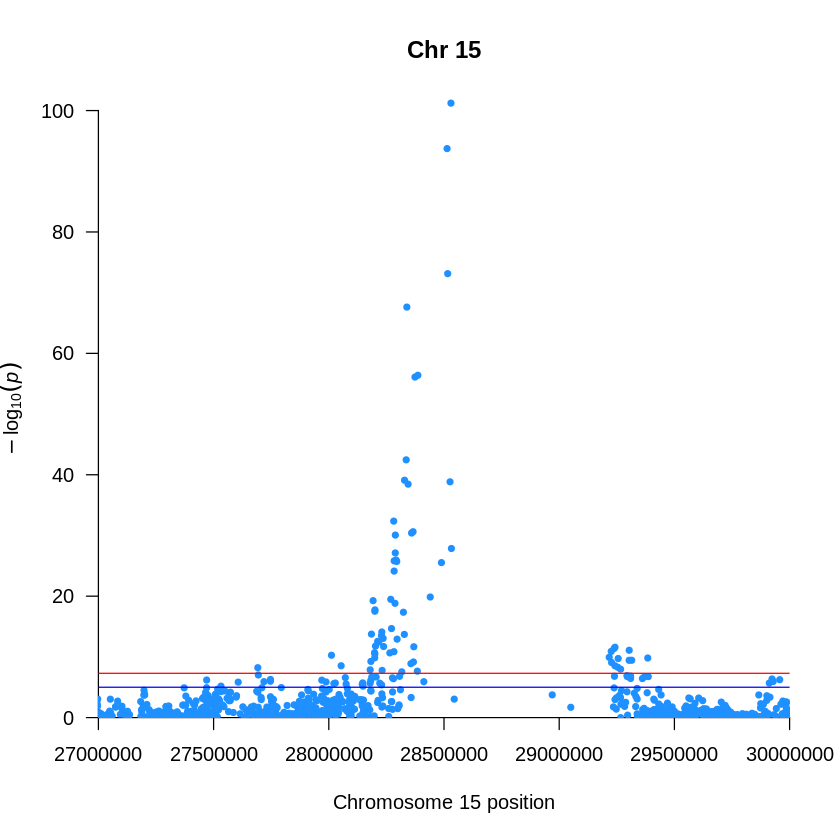

In [15]:
manhattan(subset(ass_fisher, CHR == 15,),xlim = c(27000000, 
    30000000), main = "Chr 15", col = c("dodgerblue", "dodgerblue4"))

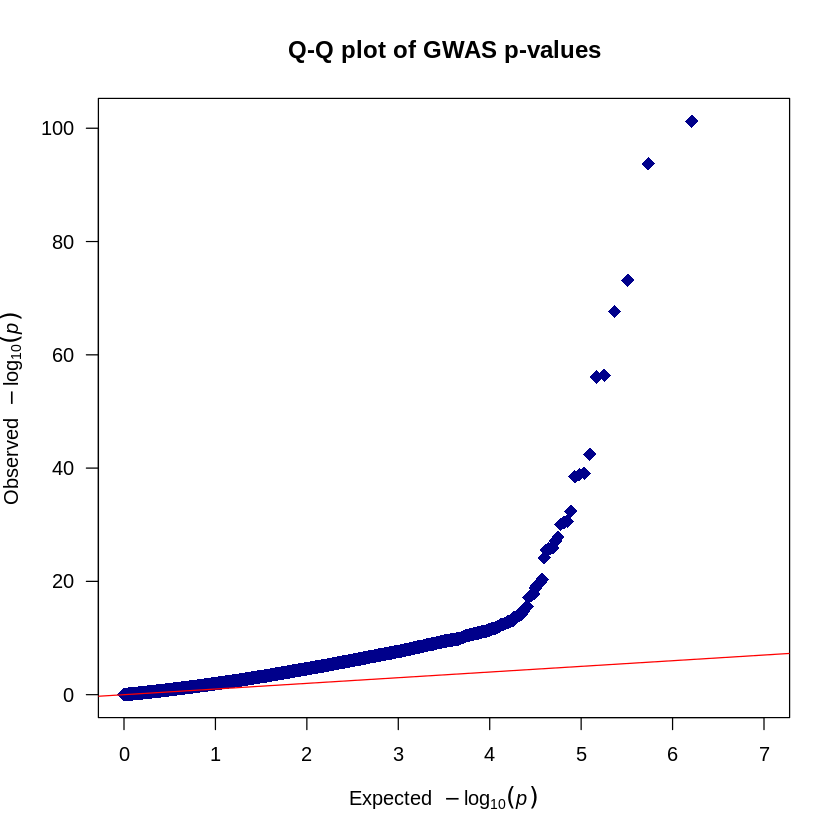

In [16]:
qq(ass_fisher$P, main = "Q-Q plot of GWAS p-values", xlim = c(0, 7), pch = 18, col = "blue4", cex = 1.5, las = 1)

We believe the SNPs from chr 15 are the ones causing this qqplot to look the way it does. 

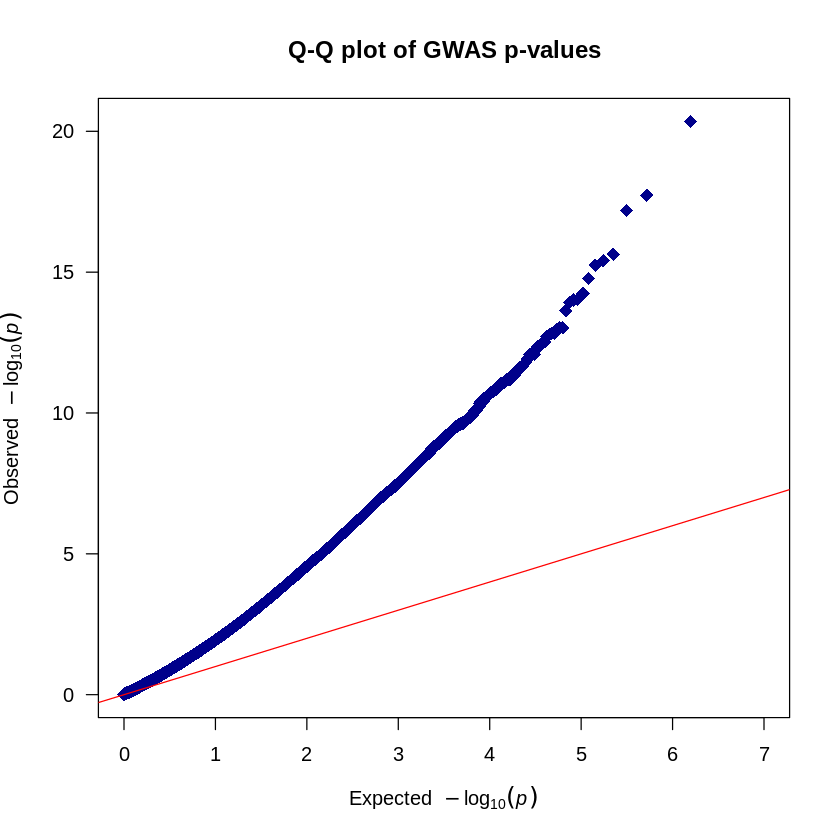

In [17]:
no15_ass_fisher <- ass_fisher%>% 
filter(CHR != "15")
qq(no15_ass_fisher$P, main = "Q-Q plot of GWAS p-values", xlim = c(0, 7), pch = 18, col = "blue4", cex = 1.5, las = 1)


We can see that Chr 15 explains most of the inflation we observe on the qqplot, so if we remove it our qqplot looks a bit better. We still have to find a way to correct for that inflation and still keep Chr 15 in our analysis since it seems to be a region of interest since we see very different p-values. 

We can try:

### Genomic Control.T

To do genomic control (to adjust for inflated test statistic) we divide the Chi-squared values by the inflation factor. The inflation factor (𝝺) can be calculated as the median of the Chi-squared statistics computed divided by the median of the Chi-squared distribution under the null.

To do a genomic control we have to:


    1 - Convert p-values to quantiles under the Chi-squared with 1 df.
    2 - Get the expected quantile under the null, e.g empirically with random samples under the null Chi-squared with 1 df.
    3 - Divide the median empiricat statistic by the expected quantile under the null (no association) (inflation faactor).
    4 - Correct the the statistic distribution by dividing with the inflation factor.

In [18]:
# Computing expected quantiles 
ass_fisher <- ass_fisher %>% 
  mutate(obs_q=qchisq(P, df=1, lower.tail = F))

exp_med <- median(rchisq(100000000,1)) # Should be 0.4549
cat("The expected median is ",exp_med)

The expected median is  0.4549757

In [19]:
#Under a the null the expected quantiles should be:
dchisq(0.5,df=1)

[1] 0.4393913

To compute the inflation factor we do measure the deviation between the empirical median and the expected median under the null.

In [20]:
lambda <- median(ass_fisher$obs_q)/exp_med
cat("\nThe inflation factor is ",lambda)


The inflation factor is  2.074418

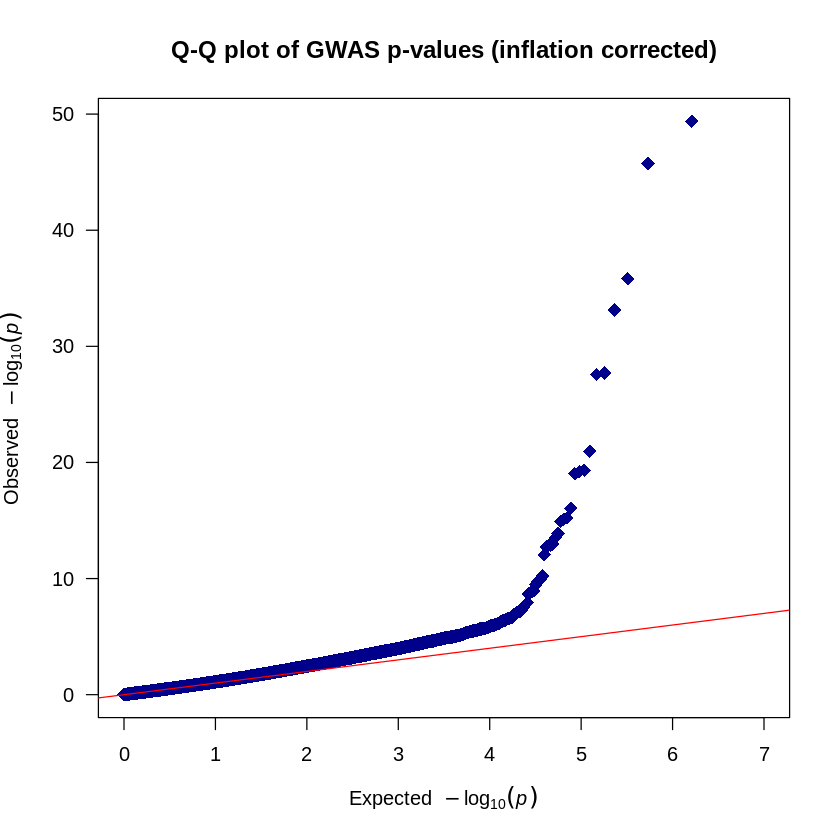

In [21]:
ass_fisher <- ass_fisher %>% 
  mutate(corr_q=obs_q/lambda) %>%
  mutate(P_corr=pchisq(corr_q, df=1, lower.tail = F))
qq(ass_fisher$P_corr, main = "Q-Q plot of GWAS p-values (inflation corrected)", xlim = c(0, 7), pch = 18, col = "blue4", cex = 1.5, las = 1)

In [22]:
cat("\nThe most significant P value after genomic control is: ",min(ass_fisher$P_corr))
cat("\nThe most significant SNP after genomic control is: ",ass_fisher[which.min(ass_fisher$P_corr),]$SNP)


The most significant P value after genomic control is:  4.188676e-50
The most significant SNP after genomic control is:  rs1667394

The corrected data looks a bit better, but we still see some inflation coming from CHR 15, this means that indeed that chromosome has to have something to do with the phenotypes we observe.

We also identify the SNP with the lowest P-Val as rs1667394 which is found unexpectedly in CHR 15.

Because the data doesn't follow exactly the line is a good idea to try additional analysis to see if we can get more results.

<span style="color:blue">**D. Try to look at the SNPs at the most significant locus. If you want to analyse it in R you can use the "--recode A" together wither the "--snp" and "--window" option in plink to get the variants around a specific SNP written to a text file that it is easy to load in R. How is the distribution of eye colors for each genotype of the most significant SNP? Is the effect additive, dominant or recessive?**</span>

## SNP analysis 

**D. Try to look at the SNPs at the most significant locus. If you want to analyse it in R you can use the "--recode A" together wither the "--snp" and "--window" option in plink to get the variants around a specific SNP written to a text file that it is easy to load in R. How is the distribution of eye colors for each genotype of the most significant SNP? Is the effect additive, dominant or recessive?**

All tests indicate that rs1667394 is the most significant SNP, we should get the variants around it and see the distribution of eye colors for each genotype of this most significant SNP to see if it's additive, dominant or recessive. 

Now we run this plink command to analyze this SNP and it's surrounding one with a window of 20:

    plink --bfile eyecolor-QC --pheno phenotypes_binary.txt --allow-no-sex --recode A --snp rs1667394 --window 20

In [23]:
surrounding <- read.table("plink.raw",header=T)
head(surrounding)
dim(surrounding)

,FID,IID,PAT,MAT,SEX,PHENOTYPE,rs16950987_A,rs1667394_C,rs16950993_G
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1010,1010,0,0,0,2,0,1,NA
2,1013,1013,0,0,0,2,0,1,0
3,1020,1020,0,0,0,1,0,0,0
4,1022,1022,0,0,0,1,0,0,0
5,1024,1024,0,0,0,1,0,0,0
6,1026,1026,0,0,0,2,0,0,0


[1] 1283    9

`summarise()` has grouped output by 'rs1667394_C'. You can override using the `.groups` argument.



rs1667394_C,PHENO,n
<int>,<chr>,<int>
0,Light Color,509
0,Dark Color,200
1,Light Color,47
1,Dark Color,320
2,Light Color,2
2,Dark Color,79


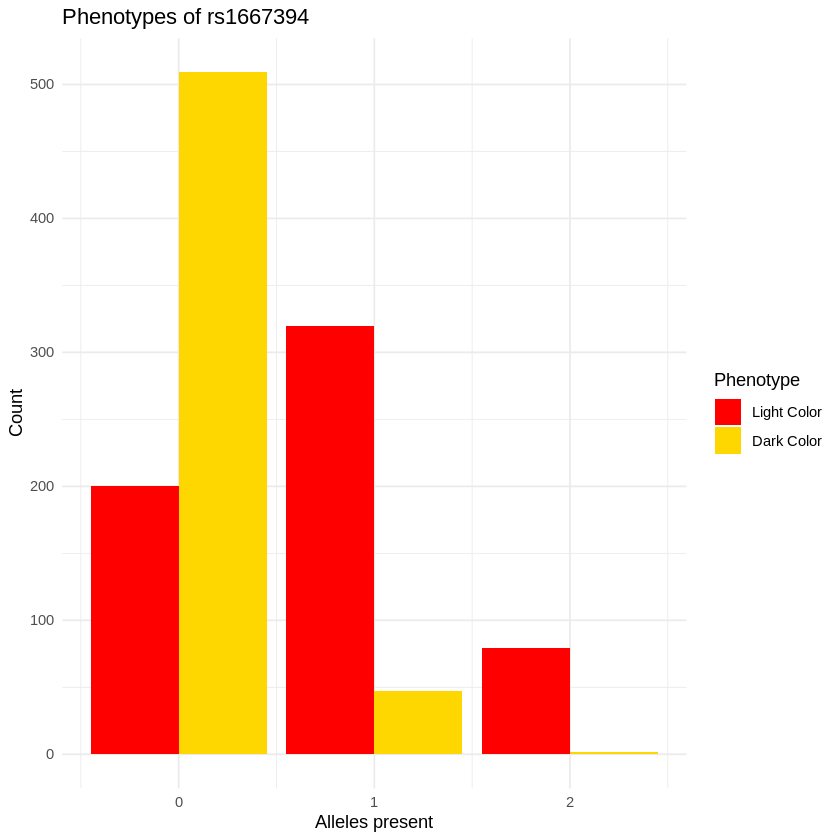

In [24]:
resp <- binary_eyecolor %>% 
    filter(!(FID %in% members))

most_significant_SNP <- surrounding %>% 
    select(matches('rs1667394'),"FID")

most_significant_SNP$PHENO <- resp$response[match(most_significant_SNP$FID, resp$FID)]
most_significant_SNP<-drop_na(most_significant_SNP)

toplot<-most_significant_SNP %>% 
    group_by(rs1667394_C, PHENO) %>% 
    summarise(n = n())  %>% 
    mutate(PHENO = recode(PHENO, 
                      "1" = "Light Color", 
                      "2" = "Dark Color"))
head(toplot)
pheno_plot1<-ggplot(data=toplot, aes(x=rs1667394_C, y=n, fill=PHENO)) + geom_bar(stat="identity",  position = "dodge")+
    scale_fill_manual(values=c("red", "gold"),labels = c("Light Color", "Dark Color"), name = "Phenotype")+theme_minimal()

print(pheno_plot1 + labs(title= "Phenotypes of rs1667394", y="Count", x = "Alleles present",fill = "Phenotype"))

This SNP generates dominant phenotypes. We can see that having just one copy changes the phenotype completely. We can also see that this SNP is associated with a dark eye color.
We can also see however, that having this SNP doesn't imply having dark eye color since we can also see some people with the SNP and with a light eye color. This means that other factors may effect the observed phenotype. 

We can plot the rest of close significant SNPs and see how they also affect the observed phenotype. 

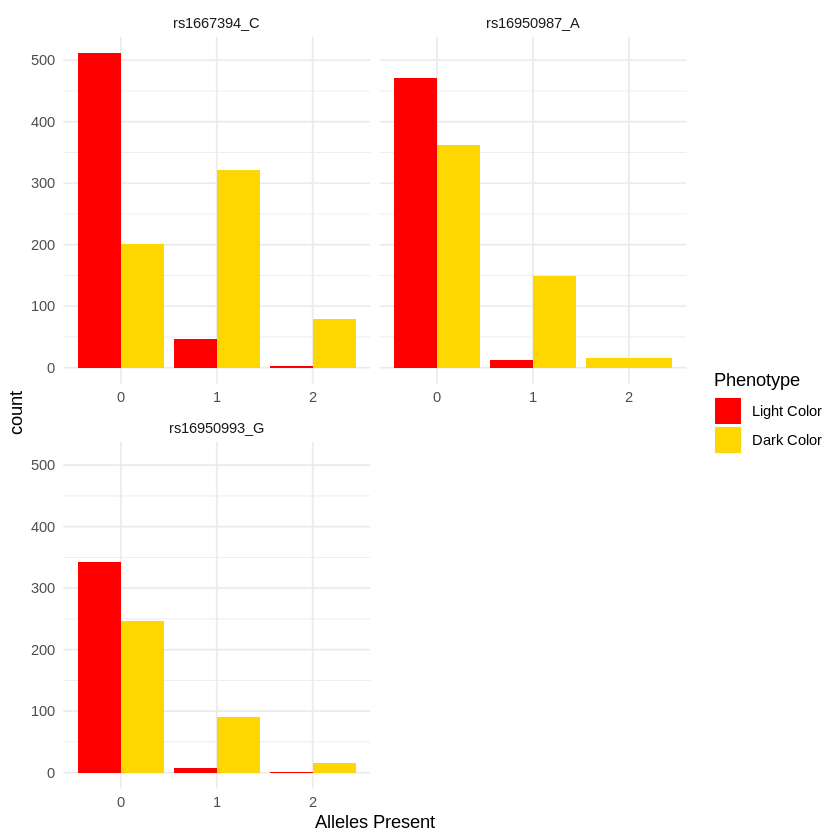

In [25]:
resp <- binary_eyecolor %>% 
    filter(!(FID %in% members))



data_gathered <- tidyr::gather(surrounding, key = variable, value = value, -c(FID, IID, PAT, MAT, SEX, PHENOTYPE)) %>% 
    drop_na()

ggplot(data_gathered, aes(x = factor(value), fill = factor(PHENOTYPE))) +
    geom_bar(position = "dodge") + 
    facet_wrap(~ variable, scales = "free_x", nrow = 2) +
    xlab("Alleles Present") + scale_fill_manual(values=c("red", "gold"),labels = c("Light Color", "Dark Color"), name = "Phenotype")+theme_minimal() 




As we can see the presence of just one of the other SNPs also seem to produce dark eye colors. This means they are also dominant. 

## We can try additional analyses using the information from the PCA or mixed models.
### Logistic Regression using PCs

We can use a logistic regression test to perform an association test while correcting for covariates. This type of correction will adjust the data using our PCs. We use the followig PLINK command: 

    plink --bfile eye_color-QC --logistic --covar eyecolor-QC.eigenvec --covar-number 1-2 --allow-no-sex --pheno phenotypes_binary.txt

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
677659,15,rs1667394,28530182,C,ADD,1157,14.7100,15.61,6.446e-55
677656,15,rs916977,28513364,T,ADD,1121,13.0900,14.74,3.624e-49
677657,15,rs8039195,28516084,C,ADD,1007,11.9500,13.42,4.843e-41
677642,15,rs4778241,28338713,A,ADD,1273,6.1020,13.35,1.253e-40
677652,15,rs11636232,28386626,T,ADD,1247,0.2884,-11.92,9.078e-33
677650,15,rs3935591,28374012,T,ADD,645,14.9900,11.34,7.901e-30


[1] 838874      9

[1] 2958

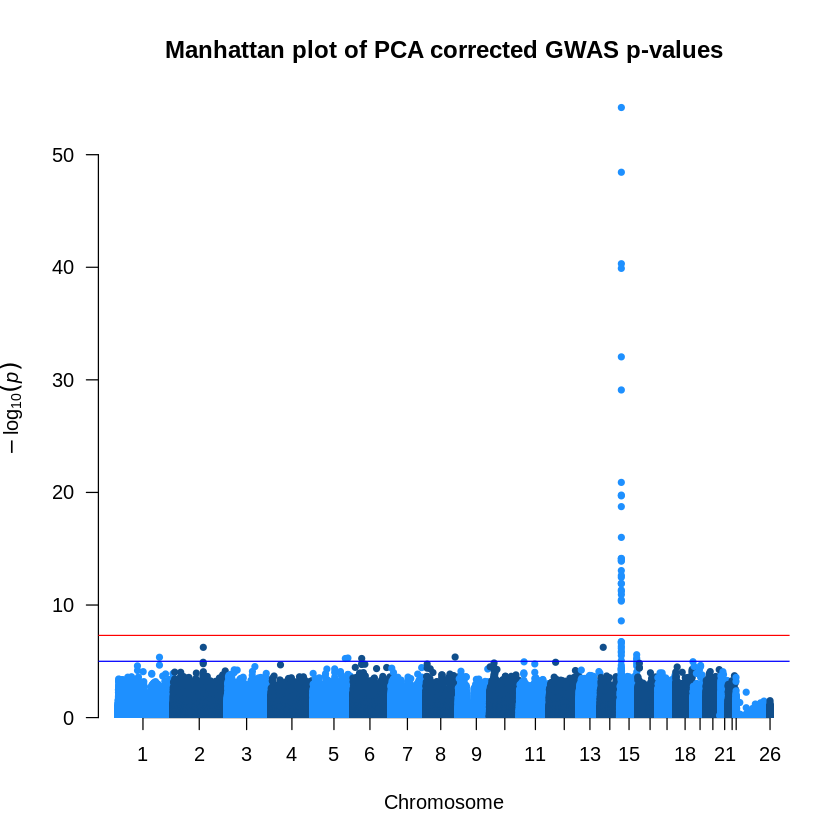

In [26]:
ass_logreg <- read.table("plink.assoc.logistic",header=T)

ass_logreg <- ass_logreg %>%
        filter(TEST == "ADD")

head(ass_logreg[order(ass_logreg$P),])


dim(ass_logreg)
sum(is.na(ass_logreg$P))

ass_logreg %>% drop_na() %>% manhattan(col = c("dodgerblue", "dodgerblue4"),main = "Manhattan plot of PCA corrected GWAS p-values")

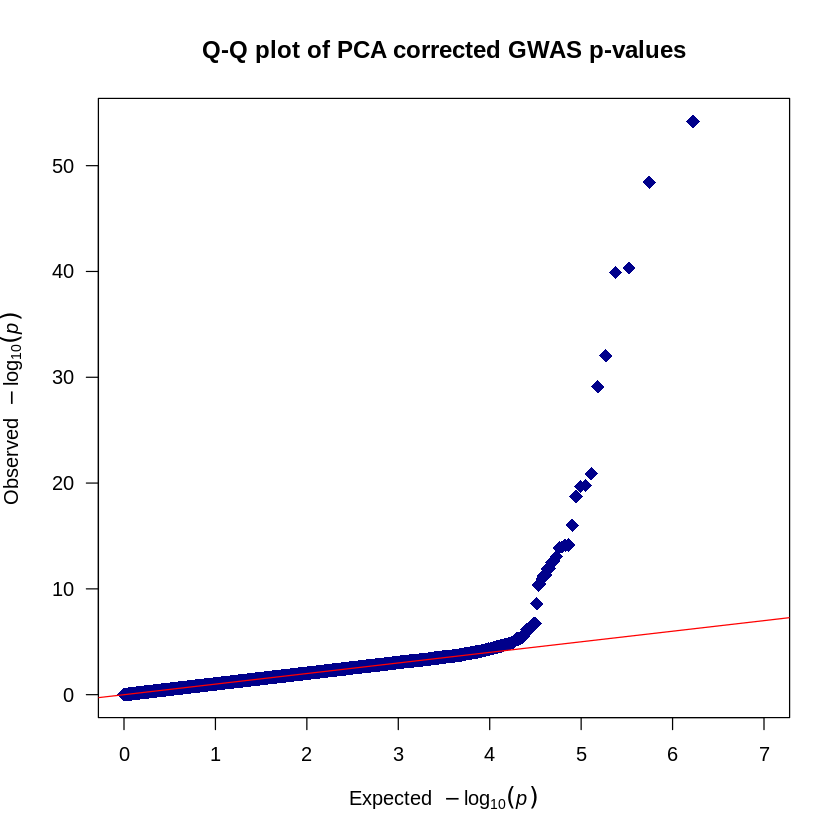

In [27]:
qq(ass_logreg$P, main = "Q-Q plot of PCA corrected GWAS p-values", xlim = c(0, 7), pch = 18, col = "blue4", cex = 1.5, las = 1)

In [28]:
ass_logreg_nona<-drop_na(ass_logreg)

In [29]:
cat("\nThe most significant P value after PCA correction is: ",min((ass_logreg_nona$P)))
cat("\nThe most significant SNP after PCA correction is: ",ass_logreg_nona[which.min(ass_logreg_nona$P),]$SNP)


The most significant P value after PCA correction is:  6.446e-55
The most significant SNP after PCA correction is:  rs1667394

In [30]:
# Compute expected quantiles 
ass_logreg_nona <- ass_logreg_nona %>% 
  mutate(obs_q=qchisq(P, df=1, lower.tail = F))

exp_med <- median(rchisq(100000000,1))
cat("The expected median is ",exp_med)

lambda <- median(ass_logreg_nona$obs_q)/exp_med
cat("\nThe inflation factor is ",lambda)

The expected median is  0.4548279
The inflation factor is  1.031386

Our inflation factor has improved considerably, from 2 to 1. 

We observe the data now follows the line more closely, meaning we are now correcting for most of the observed inflation. 

We suspect CHR 15 is the only one introducing inflation and we can check it by "removing it" and plotting the qqplot again:

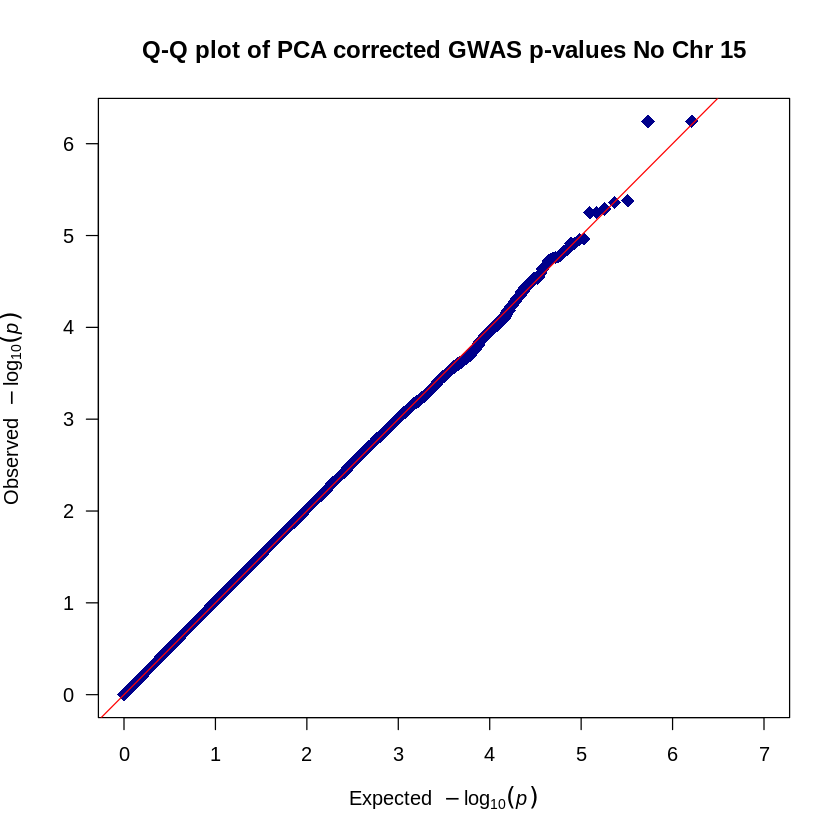

In [31]:
no15_ass_logreg <- ass_logreg%>% 
filter(CHR != "15")
qq(no15_ass_logreg$P, main = "Q-Q plot of PCA corrected GWAS p-values No Chr 15", xlim = c(0, 7), pch = 18, col = "blue4", cex = 1.5, las = 1)


We can see that indeed without CHR 15 we almost have no inflation. This means CHR 15 is the only one introducing inflation and therefore worth investigating.

We can nonetheless count and identify how many SNPs we consider significant by applying a filter on the P-Value:

In [32]:
significant <- ass_logreg %>% 
    mutate(significant = P <= 5e-5) %>% 
    filter(significant == TRUE) %>% 
    arrange(P)

sum(significant$significant == TRUE)
head(significant)


[1] 87

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P,significant
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<lgl>
1,15,rs1667394,28530182,C,ADD,1157,14.7100,15.61,6.446e-55,TRUE
2,15,rs916977,28513364,T,ADD,1121,13.0900,14.74,3.624e-49,TRUE
3,15,rs8039195,28516084,C,ADD,1007,11.9500,13.42,4.843e-41,TRUE
4,15,rs4778241,28338713,A,ADD,1273,6.1020,13.35,1.253e-40,TRUE
5,15,rs11636232,28386626,T,ADD,1247,0.2884,-11.92,9.078e-33,TRUE
6,15,rs3935591,28374012,T,ADD,645,14.9900,11.34,7.901e-30,TRUE


We identify 87 SNPs that are significant and we now how their names on a dataframe which we could use for further analysis. 

E. Do additional analyses using plink, GCTA, R or any other tool you might find relevant. 

### Test for association using a mixed model

It seems that we might be over-correcting and under-correcting. We could consider applying a mixed-model instead, which jointly model all variants while taking into account cryptic relatedness and population substructure (the genetic relatedness is included in the model).

    gcta64 --bfile eye_color-QC --make-grm --sparse-cutoff 0.05 --threads 10 --out sp_grm

    gcta64 --bfile eye_color-QC --grm-sparse sp_grm --fastGWA-mlm --pheno phenotypes_binary.txt --threads 10 --out geno_assoc

,CHR,SNP,POS,A1,A2,N,AF1,BETA,SE,P
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,rs3131972,752721,A,G,1232,0.202110,-0.00527268,0.0259407,0.838933
2,1,rs11240777,798959,A,G,1238,0.238691,0.02615060,0.0236068,0.267967
3,1,rs4970383,838555,A,C,1184,0.263091,-0.01676030,0.0243027,0.490417
4,1,rs4475691,846808,T,C,1235,0.193927,0.00551783,0.0257865,0.830562
5,1,rs7537756,854250,G,A,1220,0.203279,-0.00842823,0.0257484,0.743418
6,1,rs1110052,873558,G,T,1233,0.332928,0.01521890,0.0210086,0.468814


[1] 293822     10

[1] 0


The most significant P value after fastGWA mixed model is:  2.32291e-64
The most significant SNP after fastGWA mixed model is:  rs1667394

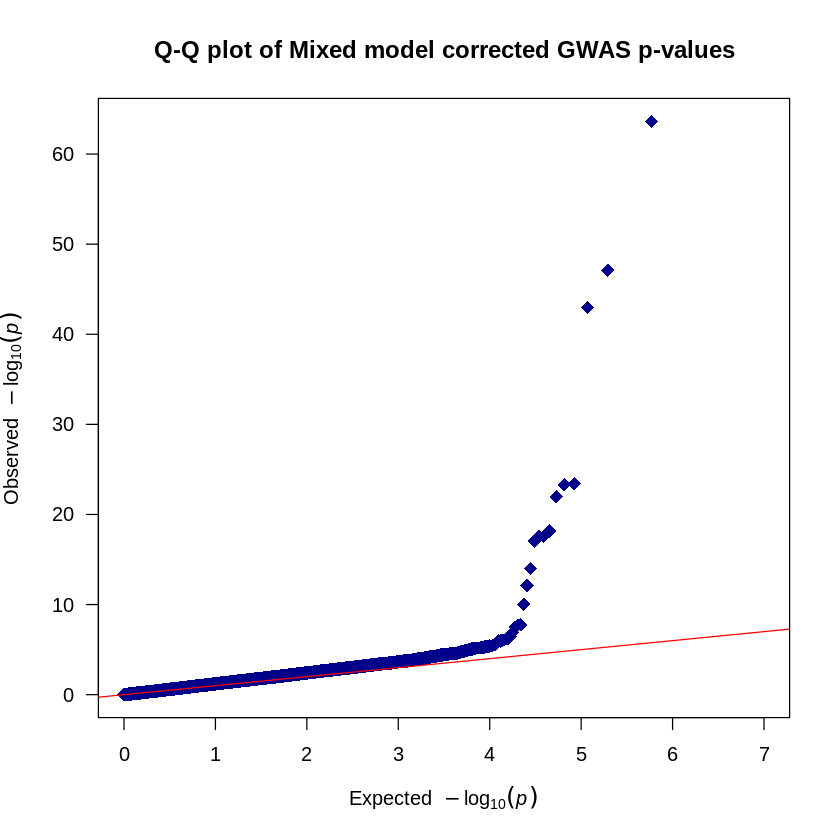

In [33]:
fastGWA <- read.table("geno_assoc.fastGWA",header=T)
head(fastGWA)

dim(fastGWA)
sum(is.na(fastGWA$P))

qq(fastGWA$P, main = "Q-Q plot of Mixed model corrected GWAS p-values", xlim = c(0, 7), pch = 18, col = "blue4", cex = 1.5, las = 1)

cat("\nThe most significant P value after fastGWA mixed model is: ",min(fastGWA$P))
cat("\nThe most significant SNP after fastGWA mixed model is: ",fastGWA[which.min(fastGWA$P),]$SNP)

## Association tests using conditioning on most the significant variant 

We can try conditioning for the most significant SNP rs1667394 running the following command:

    plink --bfile eye_color-QC --pheno phenotypes_binary.txt --allow-no-sex --logistic --covar eyecolor-QC.eigenvec --covar-number 1-2 --condition rs1667394 --out condition

In [34]:
logistic_conditioning <- read.table("condition.assoc.logistic", header = T)
head(logistic_conditioning)

dim(logistic_conditioning)
sum(is.na(logistic_conditioning$P))

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,rs3094315,752566,G,ADD,480,7.664e-01,-1.079,2.804e-01
2,1,rs3094315,752566,G,rs1667394,480,2.168e+01,11.230,2.800e-29
3,1,rs3094315,752566,G,COV1,480,3.581e-10,-2.004,4.512e-02
4,1,rs3094315,752566,G,COV2,480,1.600e+08,1.852,6.396e-02
5,1,rs3131972,752721,A,ADD,1118,7.484e-01,-1.959,5.016e-02
6,1,rs3131972,752721,A,rs1667394,1118,1.475e+01,15.270,1.247e-52


[1] 3355496       9

[1] 15964

,CHR,SNP,BP,A1,TEST,NMISS,OR,STAT,P
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,15,rs11636232,28386626,T,ADD,1131,0.4118000,-7.113,1.137e-12
2,17,rs7224003,78496495,C,ADD,978,0.4610000,-4.982,6.300e-07
3,10,rs16929939,74262353,C,ADD,560,0.0001413,-4.932,8.146e-07
4,6,rs12529268,98789325,G,ADD,629,0.2313000,-4.835,1.329e-06
5,21,rs762207,30847949,A,ADD,560,0.0002179,-4.677,2.911e-06
6,14,rs17100638,33788901,C,ADD,1119,0.0087000,-4.527,5.988e-06


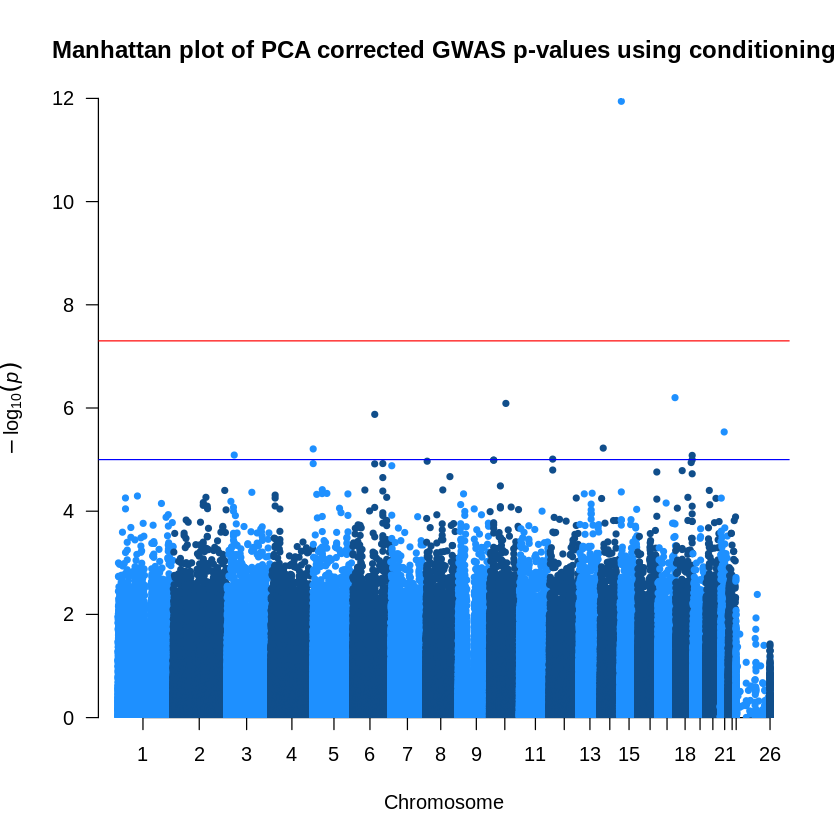

In [35]:
snps_condition <- logistic_conditioning %>% 
    filter(TEST == "ADD") %>% 
    filter(!(is.na(P)))
head(snps_condition %>% arrange(P))

manhattan(snps_condition, col = c("dodgerblue", "dodgerblue4"),main = "Manhattan plot of PCA corrected GWAS p-values using conditioning")

## Estimating Heretability
We want to estimate the amount of variance explained by the SNPs.

### Calculating the genetic relationship matrix

We will use plink to calculate the genetic relationship matrix (GRM) since it is faster than gcta.

    plink --make-grm-gz --bfile eye_color-QC --out eye_color-QC

This will save the genetic relationship matrix in the zipped file eye_color-QC.grm.gz. This matrix is computed using the sample covariance for each SNP divided by the variance.

In [36]:
d <- read.table(gzfile('eye_color-QC.grm.gz'))
names(d) <- c("sample1","sample2","variants","statistic")

grm <- d %>% 
    filter(sample1 != sample2) %>% 
    arrange(desc(statistic))

head(grm)
dim(grm)

,sample1,sample2,variants,statistic
,<int>,<int>,<int>,<dbl>
1,885,697,602095,0.8232986
2,885,118,585107,0.7486166
3,885,116,597829,0.7449819
4,885,445,601751,0.7410270
5,885,50,601738,0.7341477
6,1182,885,602559,0.7178216


[1] 809628      4

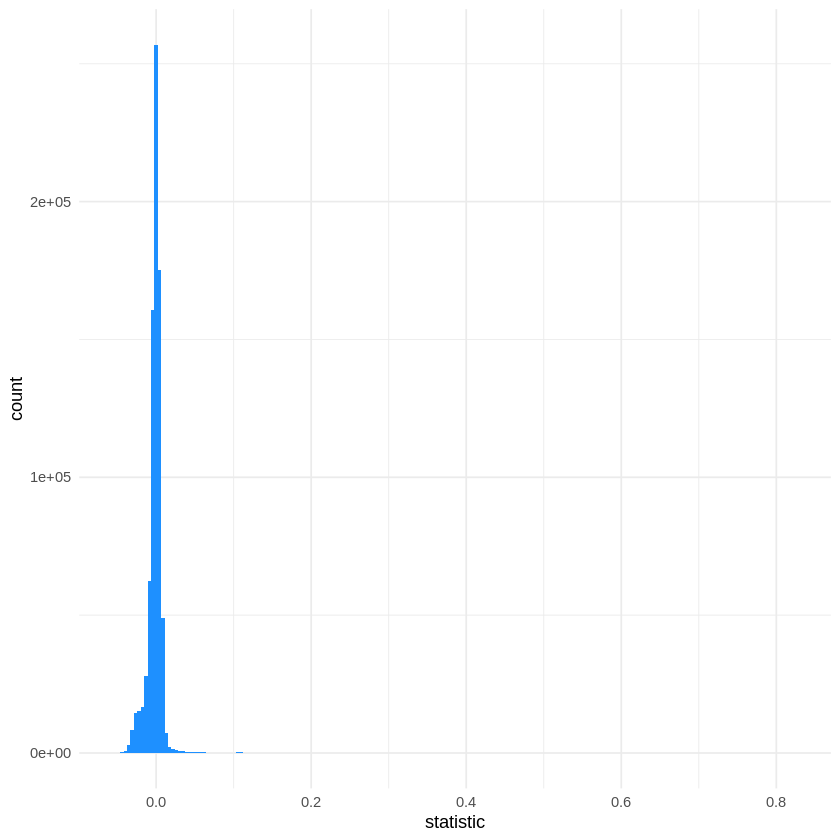

In [37]:
grm %>% 
    filter(sample1 != sample2) %>%
    ggplot(aes(x=statistic)) +
    geom_histogram(bins=200, fill="dodgerblue") +
    theme_minimal()


Using a simple head() we can observe the six highest values. These SNPs are SNPs that are closely correlated with each other, but they are not related since we filtered all related individuals during QC. 
If we plot it we can see that as expected most correlated individuals have been removed during QC but there is still some variation.

### Estimating the variance in the phenotype explained by the SNPs 

We want to measure how much of the variation we observe in our phenotypes is explained by the SNPs we have. This can be easily done in PLINK with the following commands:

    plink --make-grm-gz --bfile eye_color-QC --out eye_color-QC_all_chr

    gcta64 --grm-gz eye_color-QC_all_chr --pheno phenotypes_binary.txt --reml --out eye_color-QC_all_chr

In [38]:
reml <- read.delim('eye_color-QC_all_chr.hsq', header = TRUE)
reml

Source,Variance,SE
<chr>,<dbl>,<dbl>
V(G),0.173779,0.043619
V(e),0.053961,0.041995
Vp,0.227739,0.009101
V(G)/Vp,0.763060,0.185337
logL,308.192000,NA
logL0,242.404000,NA
LRT,131.576000,NA
df,1.000000,NA
Pval,0.000000,NA


We can see that the SNPs explain about 76% of the variance in the phenotypes we observe. 

### Estimating variance components on Chr 15

We can use gcta to estimate how much of the variance in the phenotype in eye_color-QC.phen is explained by the SNPs found in Chr 15 which seem to have the most impact according to our analysis:
    
We can compute an estimatee of heritability only on chr15 variants, by running:

    plink --make-grm-gz --chr 15 --bfile eye_color-QC --out eye_color-QC_chr15

    gcta64 --grm-gz eye_color-QC_chr15 --pheno phenotypes_binary.txt --reml --out eye_color-QC_chr15

    We can get the number of variants at chr15 by running:

    less -S eye_color-QC.bim|awk '{if ($1 == "15") print}'|wc -l
    
    25669 Variants are observed
    


,sample1,sample2,variants,statistic
,<int>,<int>,<int>,<dbl>
1,885,697,18626,1.0556250
2,835,697,25540,0.9350658
3,885,25,18576,0.9027085
4,885,118,18179,0.9012758
5,697,25,25265,0.8948432
6,885,445,18637,0.8920091


[1] 809628      4

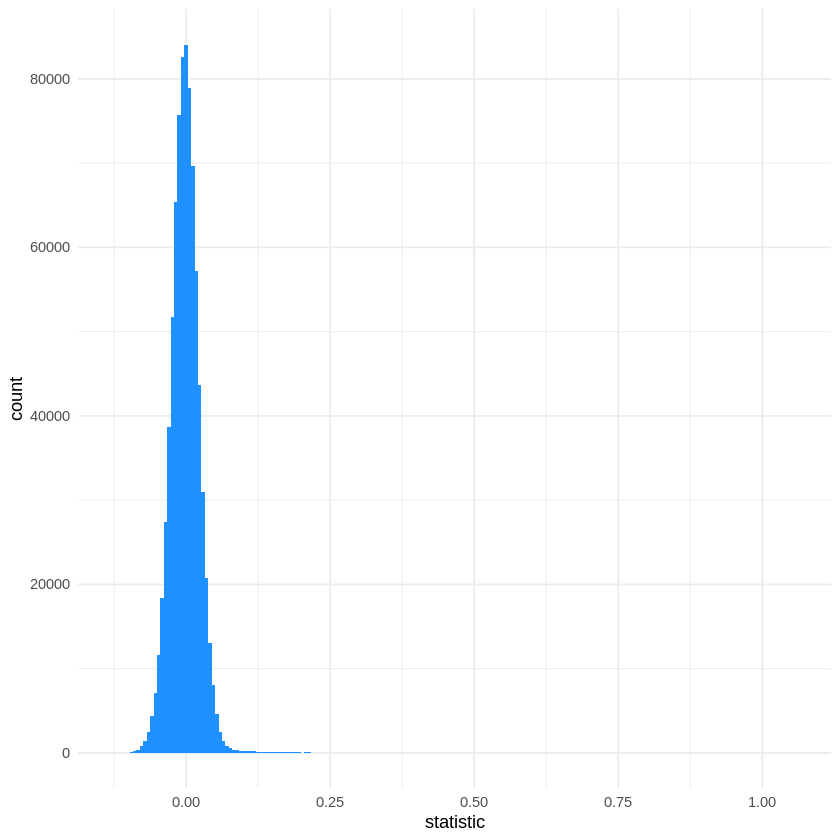

In [39]:
d <- read.table(gzfile('eye_color-QC_chr15.grm.gz'))
names(d) <- c("sample1","sample2","variants","statistic")

grm <- d %>% 
    filter(sample1 != sample2) %>% 
    arrange(desc(statistic))

head(grm)
dim(grm)

grm %>% 
    filter(sample1 != sample2) %>%
    ggplot(aes(x=statistic)) +
    geom_histogram(bins=200, fill="dodgerblue") +
    theme_minimal()

In [40]:
reml <- read.delim('eye_color-QC_chr15.hsq', header = TRUE)
reml

Source,Variance,SE
<chr>,<dbl>,<dbl>
V(G),0.091572,0.014476
V(e),0.138894,0.012718
Vp,0.230466,0.009488
V(G)/Vp,0.397336,0.056408
logL,319.381000,NA
logL0,242.404000,NA
LRT,153.954000,NA
df,1.000000,NA
Pval,0.000000,NA


The variance observed in the phenotypes explained by genotypic variance of chr 15 is aprox 39,7%. 
